## Import all necessary packages to notebook

In [1]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import json
import lightgbm as lgb
import shap
from IPython.display import clear_output
##### basic tool bos for operation
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import numpy as np
import pandas as pd
import random
import os
random.seed(100)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Function to classify specified dataset, this is to run out-of -the sample classification aka Mouse wise classification

The idea behind classification is to take out few mice data completly and train model with rest of the data. Once model is trained run validation using remaining data. The function iterates nreps times, randomly selecting n_test_samples samples for testing and the remaining for training. It then fits a LightGBM classifier to the training data and evaluates it on the test data. For each model iteration, it calculates various metrics such as accuracy, F1 score, AUC score, and SHAP values for both training and test data.

The results are stored in a dictionary report_from_model, which contains DataFrames for AccuracyTrain, AccuracyTest, f1_class0, f1_class1, auc_Score, SHAP_train, and SHAP_test.

This function is designed to provide insights into model performance and feature importance for the given classification task

In [2]:
def run_classification(nreps, MouseList, n_test_samples, metaCol, clss_col_name,  top5_parameters, df_to_class = None):
    """This function is designed to run classification takes below arguements
    nreps = Number of repetition to run example it randomly samples the...
            data again and again runs the classification for nreps (for ms it is 100)
    MouseList = A list of mice list in data set, which can also used....
                to filter out data form mouse which need to be excluded (simply not left out from the list will be excluded)
    n_test_samples = Number to specify the test (validation) data size
    df_tim_filt = df frame which contains the data 2D (n_trials and n_mice X freatures and metacolumns) 
    metaCol = Column names which contains meta information about data such has miceID, time_intervals, drugID,..etc
    clss_col_name = cloumn name which has class ID (it could be drug name or drug ID in this case)
    top5_parameters = A dictionary has top 5 model parameters                
    """
    report_from_model = {
        'AccuracyTrain': pd.DataFrame(),
        'AccuracyTest' : pd.DataFrame(),
        'f1_class0'    : pd.DataFrame(),
        'f1_class1'    : pd.DataFrame(),
        'auc_Score'    : pd.DataFrame(),
        'SHAP_train'   : pd.DataFrame(),
        'SHAP_test'    : pd.DataFrame()}
    
    ## Iteration n repetition
    for idx in range(0, nreps):
        
        testList  = random.sample(MouseList, n_test_samples)
        trainList = [i for i in MouseList if i not in testList] ## collect data which is not in test list
        testList.sort()
        trainList.sort()
   
        ### Select desired TimBins only 
        df_train = df_to_class[df_to_class['MouseID'].isin(trainList)]                
        df_test  = df_to_class[df_to_class['MouseID'].isin(testList)]
        
        X_train = df_train.drop(metaCol, axis = 1)
        X_test  = df_test.drop(metaCol, axis = 1)
    
        label_encoder = LabelEncoder()
        y_train = pd.Series(label_encoder.fit_transform(df_train['DrugID']))
        y_test  = pd.Series(label_encoder.fit_transform(df_test['DrugID']))
   
        print('Training data class counts is ', y_train.value_counts())
        print('Test data class counts is ',y_test.value_counts())
    
        ## Iteration through top 5 models
        for ModIdx, modelName in enumerate(modelList):
            optim_parms = top5_parameters[str(ModIdx)]    
            model = lgb.LGBMClassifier(**{**basic_params,**optim_parms})                          
               
            print('computing Classififcation for -', '--model-', modelName, ' repetition-', str(idx))
            
            model.fit(X_train, y_train)
            
            ### Get the model trained accurac 
            """It is not used in general just to cross check the trained accuracy with test accuracy
            if train accuracy is too different than test accuracy the the model is not performing good"""                
            y_train_pred = model.predict(X_train)
            ### Calculate the training accuracy
            train_accuracy = accuracy_score(y_train, y_train_pred)                
            report_from_model['AccuracyTrain'].loc[idx, modelName] = train_accuracy;                
          
            ### Get SHAP values for Train data                
            explainer_train   = shap.TreeExplainer(model)
            shap_values_train = explainer_train(X_train, y_train)                
            vals_train        = shap_values_train.values                
            vals_train_abs    = np.abs(vals_train)
            val_train_mean    = np.mean(vals_train_abs, axis=2)                 
            val_train_final   = np.mean(val_train_mean, axis = 0) 
            temp_shap = pd.DataFrame(val_train_final)
            temp_shap.columns = [modelName]                
            report_from_model['SHAP_train'] = pd.concat([report_from_model['SHAP_train'], temp_shap.T], axis = 0);
                        
            """-------------------------------------------------------------------------------------"""            
            ### Predict test data set using trained model 
            """this is important step in the classification""" 
            y_pred = model.predict(X_test)                  
   
            ### Get SHAP values for Test data
            explainer_test   = shap.TreeExplainer(model)
            shap_values_test = explainer_test(X_test, y_test)                
            vals_test        = shap_values_test.values                
            vals_test_abs    = np.abs(vals_test)
            val_test_mean    = np.mean(vals_test_abs, axis=2) 
            val_test_final   = np.mean(val_test_mean, axis = 0)                 
            temp_shap = pd.DataFrame(val_test_final)
            temp_shap.columns = [modelName]                
            report_from_model['SHAP_test'] = pd.concat([report_from_model['SHAP_test'], temp_shap.T], axis = 0);   
          
            ### Calculate Area under the curve
            auc = roc_auc_score(y_test, y_pred)
            report_from_model['auc_Score'].loc[idx, modelName] = auc;                
                           
            ### Calculate the accuracy score add to loop list
            Accuracy = accuracy_score(y_test, y_pred, normalize=True)
            report_from_model['AccuracyTest'].loc[idx, modelName] = Accuracy;           
            
            ### Calculate F1 score and add to data stracture
            class_report= classification_report(y_test, y_pred, target_names=[0,1],
                                                output_dict=True,  zero_division=0)                
            F1ScoreList  = pd.DataFrame(class_report).transpose()['f1-score']
            
            report_from_model['f1_class0'].loc[idx, modelName] = F1ScoreList[0];
            report_from_model['f1_class1'].loc[idx, modelName] = F1ScoreList[1];            
            """-------------end of model loop--------------------------------------- """   
    
    return report_from_model



## Load connectivity or PSD data and parameters 

This snippet loads an Excel file located at the specified path (ExcelPath) with the given name (ExcelName). It reads the data from a specific sheet (sheet_name) within the Excel file into a pandas DataFrame (df).

Additionally, it loads top 5 parameters for LightGBM (LGBM) models from a JSON file located at parms_dict_path with the name params_file_name. These parameters are stored in a dictionary called params_dict.

The basic_params dictionary contains basic parameters for the LGBM models, such as objective, metric, boosting type, and verbosity.

The modelList is a list of model names used for classification. In this case, it seems to contain 'LG1', 'LG2', 'LG3', 'LG4', and 'LG5'.

This script snippet seems to be a part of a larger analysis or modeling process involving the classification of connectivity data using LGBM models, with parameters stored in a JSON file.

In [3]:
# ###Connectivity Files info and get all sheet in excel
ExcelPath = os.getcwd()
ExcelName = 'SIFT connectivity data with final exclusion.xlsx'
sheet_name = 'GGC_PreInjBaseline'
df = pd.read_excel(os.path.join(ExcelPath, ExcelName), sheet_name = sheet_name)
###------------------------------------------------------------------

### Information and Read the top5 parameters JSON
parms_dict_path = os.getcwd()
params_file_name = 'Top5 parameters for LGBM SIFT freq-subspace optuna results for GGC_PreInjBaseline.json'

with open(os.path.join(parms_dict_path,params_file_name), "r") as json_file:
    params_dict = json.load(json_file)
###------------------------------------------------------------------

basic_params = {'objective': 'binary',
                'metric': 'binary_logloss',
                'boosting_type': 'gbdt',
                'verbosity': -1}

modelList = ['LG1',             
             'LG2',
             'LG3',
             'LG4',
             'LG5']

This cell initializes several variables, including dictionaries to store classification results. It sets up experimental parameters such as the number of repetitions, whether to consider frequency subspaces, class column name, number of test samples, and defines drug IDs and combinations.

The script creates intervals based on experimental durations and trial durations. It then iterates over drug combinations and time intervals, filtering the data accordingly. Within each iteration, it runs classification models, storing results in dictionaries for each time interval and frequency band.

Finally, it aggregates results into dictionaries organized by drug combinatiary:

Experimental parameters are initia
ized.
Intervals are created based on experimental dur
tions.
The script iterates over drug combinations and time intervals.
Classification models are run and results stored in dictionaries.
Results are aggregated into dictionaries organized by drug comb
inations.
Overall, this script is designed to analyze and classify data based on drug combinations and time intervals, storing the results for further analysis or visualization.

In [4]:
nreps = 100;
FeqSubSpace = True
clss_col_name = 'DrugID'
n_test_samples = 2
freqBands = ['Delta', 'Theta', 'Beta', 'LoGamma', 'MidGamma', 'HiGamma']
metaCol = ['times','MouseID','ExptDay','DrugID', 'DrugName']
feature_columns = [col for col in df.columns if col not in metaCol]

DrugIds = {1:'Sal',
           2:'SalT',
           3:'Amph',
           4:'Raclo',
           5:'SCH',
           6:'CLZ1',
           7:'CLZ3'}

if FeqSubSpace and freqBands:    
    drg_combinations = {'Amph' :['Amph','Sal'],                   
                        'Raclo':['Raclo','SalT'],
                        'SCH'  :['SCH', 'Sal'],
                        'CLZ1' :['CLZ1','Sal'],
                        'CLZ3' :['CLZ3','Sal']}
else:
    drg_combinations = {'Amph' :['Amph','Sal'],                   
                        'Raclo':['Raclo','SalT'],
                        'SCH'  :['SCH', 'Sal'],
                        'CLZ1' :['CLZ1','Sal'],
                        'CLZ3' :['CLZ3','Sal'],
                        'Sal'  :['SalT','Sal']}
    
interval_bin_dur = 10 ## Mins
total_expt_dur   = 60 ## Mins
trial_dur = 20 ## Secs
time_index1 = list(range(interval_bin_dur, total_expt_dur+1, interval_bin_dur))
time_index2 = list(range(trial_dur, (total_expt_dur*total_expt_dur)+1, trial_dur))
    
final_intervals = {}
for idx, x in enumerate(time_index1):
    key = f'{x}_min'
    """The value 30 is number obtained as 20s intervals for 10 mins i.e. give 30 trials """
    value = time_index2[idx * 30 : (idx + 1) * 30]  # Get the slice of time_index2
    final_intervals[key] = value

AccuracyTrain = {};
AccuracyTest  = {};
F1_class0     = {};
F1_class1     = {};
AUCScore      = {};
SHAP_train    = {};
SHAP_test     = {};

for drg_cmb in drg_combinations.keys():

    ## Final Mouse List
    ## for Amphetamine 518 and 587 mouse excluded because of LMA
    if 'Amph' in drg_cmb:
        MouseList = [530, 574, 591, 303, 304, 305, 336, 340]
        print(MouseList)
    else:
        MouseList = [530, 574, 591, 518, 587, 303, 304, 305, 336, 340]
        print(MouseList)
 
    ## Get the data for specific drug combination        
    df_drg_filt = df[df['DrugName'].isin(drg_combinations[drg_cmb])]
     
    ### Get TimBin list   
    TimBinAccuracyTrain = {};
    TimBinAccuracyTest  = {};
    TimBinF1_class0  = {};
    TimBinF1_class0  = {};
    TimBinAUCScore   = {};
    TimBinSHAP_train = {};
    TimBinSHAP_test  = {};
    TimBin_mouse_List= {};

    # Initialize dictionaries with empty dictionaries for each TimBin key
    TimBinAccuracyTrain = {TimBin: {} for TimBin in final_intervals.keys()}
    TimBinAccuracyTest = {TimBin: {} for TimBin in final_intervals.keys()}
    TimBinF1_class0 = {TimBin: {} for TimBin in final_intervals.keys()}
    TimBinF1_class1 = {TimBin: {} for TimBin in final_intervals.keys()}
    TimBinAUCScore = {TimBin: {} for TimBin in final_intervals.keys()}
    TimBinSHAP_train = {TimBin: {} for TimBin in final_intervals.keys()}
    TimBinSHAP_test = {TimBin: {} for TimBin in final_intervals.keys()}
    
    for int_Idx, TimBin in enumerate(final_intervals):   
        ## Get the data for specific time interval
        df_tim_filt = df_drg_filt[df_drg_filt['times'].isin(final_intervals[TimBin])]
       
        if FeqSubSpace and freqBands: 
            for freq in freqBands :
                ## clear the notebook cell ouput (helps to reduce workload)
                clear_output(wait=False)
                drg_cmb_name = f'{drg_combinations[drg_cmb][0]} vs {drg_combinations[drg_cmb][1]}' 
                top5_parameters = params_dict[f'{drg_cmb_name}_{freq}'] 

                ##get a list of all col names which contains specified freq-band name
                freq_col = [col for col in df_drg_filt.columns if f'_{freq}' in col]
            
                filtered_col = metaCol + freq_col ### Combine meta column and freq-specific list
                df_freq_filt = df_tim_filt[filtered_col] ### Filter the data to get only specific freqband data 
                              
                report_from_model = run_classification(nreps, MouseList, n_test_samples, metaCol,
                                                       clss_col_name, top5_parameters, df_to_class = df_freq_filt)
                ### TimBins Loop    
                TimBinAccuracyTrain[TimBin][freq] =  report_from_model['AccuracyTrain'];
                TimBinAccuracyTest[TimBin][freq]  =  report_from_model['AccuracyTest'];   
                TimBinF1_class0[TimBin][freq]  =  report_from_model['f1_class0'];
                TimBinF1_class0[TimBin][freq]  =  report_from_model['f1_class1'];
                TimBinAUCScore[TimBin][freq]   =  report_from_model['auc_Score'];
                TimBinSHAP_train[TimBin][freq] =  report_from_model['SHAP_train'];
                TimBinSHAP_test[TimBin][freq]  =  report_from_model['SHAP_test'];
        
        elif FeqSubSpace and not freqBands:
            print('There is no frq band list or list is empty check the list and run cell again')

        else:
            ## clear the notebook cell ouput (helps to reduce workload)
            clear_output(wait=False)
            drg_cmb_name = f'{drg_combinations[drg_cmb][0]} vs {drg_combinations[drg_cmb][1]}' 
            top5_parameters = params_dict[drg_cmb_name]           
            report_from_model = run_classification(nreps, MouseList, n_test_samples, metaCol,
                                                       clss_col_name, top5_parameters, df_to_class = df_tim_filt)

            ### TimBins Loop    
            TimBinAccuracyTrain[TimBin]['all'] =  report_from_model['AccuracyTrain'];
            TimBinAccuracyTest[TimBin]['all']  =  report_from_model['AccuracyTest'];   
            TimBinF1_class0[TimBin]['all']  =  report_from_model['f1_class0'];
            TimBinF1_class0[TimBin]['all']  =  report_from_model['f1_class1'];
            TimBinAUCScore[TimBin]['all']   =  report_from_model['auc_Score'];
            TimBinSHAP_train[TimBin]['all'] =  report_from_model['SHAP_train'];
            TimBinSHAP_test[TimBin]['all']  =  report_from_model['SHAP_test'];
     
    """-------------------end of TimBins loop-------------------------------------"""
    AccuracyTrain[drg_cmb_name] = TimBinAccuracyTrain
    AccuracyTest[drg_cmb_name]  = TimBinAccuracyTest
    F1_class0[drg_cmb_name]     = TimBinF1_class0
    F1_class1[drg_cmb_name]     = TimBinF1_class0
    AUCScore[drg_cmb_name]      = TimBinAUCScore
    SHAP_train[drg_cmb_name]    = TimBinSHAP_train
    SHAP_test[drg_cmb_name]     = TimBinSHAP_test

Training data class counts is  0    180
1    180
Name: count, dtype: int64
Test data class counts is  0    60
1    60
Name: count, dtype: int64
computing Classififcation for - --model- LG1  repetition- 0
computing Classififcation for - --model- LG2  repetition- 0
computing Classififcation for - --model- LG3  repetition- 0
computing Classififcation for - --model- LG4  repetition- 0
computing Classififcation for - --model- LG5  repetition- 0
Training data class counts is  0    180
1    180
Name: count, dtype: int64
Test data class counts is  1    60
0    60
Name: count, dtype: int64
computing Classififcation for - --model- LG1  repetition- 1
computing Classififcation for - --model- LG2  repetition- 1
computing Classififcation for - --model- LG3  repetition- 1
computing Classififcation for - --model- LG4  repetition- 1
computing Classififcation for - --model- LG5  repetition- 1
Training data class counts is  0    180
1    180
Name: count, dtype: int64
Test data class counts is  1    60
0 

KeyboardInterrupt: 

## Save the Result from classification as pkl for future use.

In [16]:
all_results_together = {
    'WT_AccuracyTrain':AccuracyTrain,
    'WT_AccuracyTest' : AccuracyTest,
    'WT_F1_class0'    : F1_class0,
    'WT_F1_class1'    : F1_class1,
    'WT_AUCScore'     : AUCScore,
    'WT_SHAP_train'   : SHAP_train,
    'WT_SHAP_test'    : SHAP_test,    
    'params_dict'      : params_dict,
    'basic_params'     : basic_params,
    'final_intervals'  : final_intervals,
    'DrugIds'          : DrugIds,
    'drg_combinations' : drg_combinations,      
    'freqBands'        : freqBands,
    'FeqSubSpace'      : True
}

import pickle
if FeqSubSpace:
    pkl_name = 'Freq subspace'
else:
    pkl_name = 'all freq together'
    
with open(f'{sheet_name} {pkl_name} LGBM 100x Classification.pkl', 'wb') as file:
    pickle.dump(all_results_together, file)


## Plot and save the accuracy values

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
findfont: Font family ['Arial'] not found. Falling back to Helvetica.
findfont: Font family ['Arial'] not found. Falling back to Helvetica.
findfont: Font family ['Arial'] not found. Falling back to Helvetica.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: 

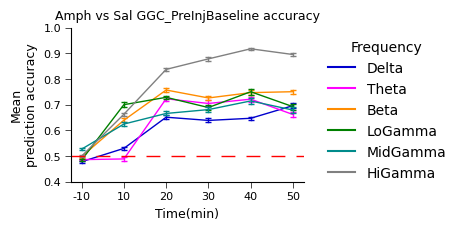

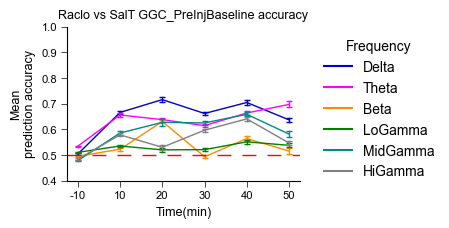

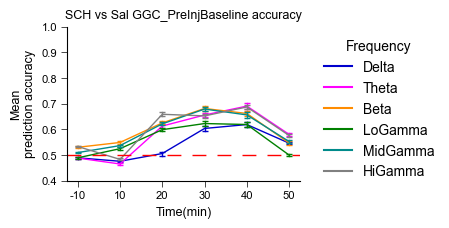

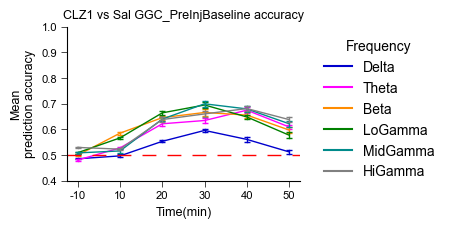

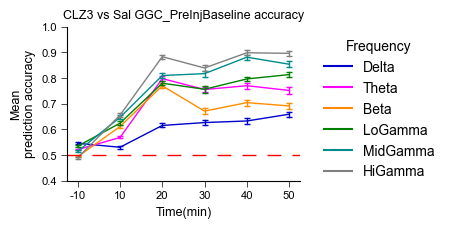

In [7]:
def plot_accuracy(plt_accuracy_df,x, y, hue, legend_title, fig_ttl, xticklabels = None, 
                  figsize=(3, 2), palette=['mediumblue', 'magenta', 'darkorange', 'green', 'darkcyan', 'grey'],
                  errorbar='se', err_style='bars', err_kws={'capsize':2, 'elinewidth' : 1, 'capthick':1},
                  TickLabsize = 8 , textSize = 9, save_fig = False):
    """
    Parameters:
        plt_accuracy_df (DataFrame): The DataFrame containing accuracy data.
        x (str): The column name for the x-axis data.
        y (str): The column name for the y-axis data.
        hue (str): The column name to map plot aspects to different colors.
        legend_title (str): The title for the legend.
        fig_ttl (str): The title for the figure.
        xticklabels (list, optional): Custom labels for x-axis ticks. Default is ['-10', '10', '20', '30', '40', '50'].
        figsize (tuple, optional): Figure size (width, height) in inches. Default is (3, 2).
        palette (list, optional): Color palette for the plot. Default is ['mediumblue', 'magenta', 'darkorange', 'green', 'darkcyan', 'grey'].
        errorbar (str, optional): Method to draw error bars. Default is 'se'.
        err_style (str, optional): Style of error bars. Default is 'bars'.
        err_kws (dict, optional): Additional parameters for error bars. Default is {'capsize':2, 'elinewidth' : 1, 'capthick':1}.
        TickLabsize (int, optional): Font size for tick labels. Default is 8.
        textSize (int, optional): Font size for text elements. Default is 9.
        save_fig (bool, optional): Whether to save the figure as a PDF and JPEG file. Default is False.

        Example Usage:
        
        plot_accuracy(plt_accuracy_df, x='tbin', y='TestAccuracy', hue='freqBand',
              legend_title='Frequency', fig_ttl='Accuracy Plot', save_fig=True)
    """

    if xticklabels is None:
        xticklabels = ['-10','10','20','30','40','50']        
        
    fig, axs = plt.subplots(ncols=1, sharex=False, sharey=False,
                             constrained_layout=False, figsize=figsize)
    
    ax1 = sns.lineplot(ax = axs, x=x, y=y, hue=hue, data=plt_accuracy_df,
                        palette = palette, errorbar =  errorbar, err_style=err_style, err_kws=err_kws)
    ax1.axhline(y=0.5, linewidth=0.5, color="red", dashes=[10, 8])
    # Create a legend with handles and labels and place it outside the plot
    ax1.legend(title=legend_title, bbox_to_anchor=(1.05, 1), loc='upper left',  frameon=False)
    ax1.set_xticklabels(xticklabels, rotation=0, horizontalalignment='center', fontsize = 9)

    # Additional customization for ax1
    for line in ax1.lines:
        line.set_linewidth(1)

    ax1.tick_params(direction='out', length=4, width=0.5, colors='k', grid_color='k', grid_alpha=1, pad=0.3)
    
    ax1.spines[['right', 'top']].set_visible(False)
    ax1.set_title(fig_ttl, size=textSize)
    
    ax1.set_ylabel('Mean\nprediction accuracy', fontsize=textSize)
    ax1.set_xlabel('Time(min)', fontsize=textSize)
    ax1.set_ylim([0.4, 1])
    ax1.tick_params(axis='x', which='major', pad=3, labelsize=TickLabsize)
    ax1.tick_params(axis='y', which='major', pad=3, labelsize=TickLabsize)
 
    figName = f' {fig_ttl}_100X accuracy.pdf' 
    figName2 = f' {fig_ttl}_100X accuracy.jpg' 
    
    if save_fig:
        plt.rcParams['pdf.use14corefonts'] = True
        plt.rcParams["font.family"] = "Arial"
        plt.savefig(figName,  dpi = 300, bbox_inches='tight', transparent=True, metadata={'Creator': None})
        plt.savefig(figName2,  dpi = 300, bbox_inches='tight', transparent=True)

###---------------------------------- Plot the accuracy results ------------------------------------------------

# Initialize an empty DataFrame to store final accuracy data
final_accuracy = pd.DataFrame()

# Iterate through each drug combination in the AccuracyTest dictionary
for DrgCmb in AccuracyTest.keys():
    # Initialize an empty DataFrame to store frequency bin data
    fbin_df = pd.DataFrame()
    # Iterate through each frequency in the first drug combination
    for freq in AccuracyTest[DrgCmb][list(AccuracyTest[DrgCmb].keys())[0]].keys():
        # Initialize an empty DataFrame to store time bin data
        tbin_df = pd.DataFrame()
        # Iterate through each time bin in the current drug combination
        for tbin in AccuracyTest[DrgCmb].keys():
            # Calculate the mean accuracy for the current frequency and time bin
            tbin_df[tbin] = AccuracyTest[DrgCmb][tbin][freq].mean(axis=1)
        # Add a column 'freqBand' with the current frequency to the time bin DataFrame
        tbin_df['freqBand'] = freq
        # Concatenate the time bin DataFrame with the frequency bin DataFrame
        fbin_df = pd.concat([fbin_df, tbin_df], axis=0)
    # Add a column 'DrgCmb' with the current drug combination to the frequency bin DataFrame
    fbin_df['DrgCmb'] = DrgCmb
    # Concatenate the frequency bin DataFrame with the final accuracy DataFrame
    final_accuracy = pd.concat([final_accuracy, fbin_df], axis=0)

# Melt the final accuracy DataFrame to long format
plt_accuracy_df = final_accuracy.melt(id_vars=['freqBand', 'DrgCmb'], var_name='tbin', value_name='TestAccuracy')

# Set save_fig to True
save_fig = True

# Check if there is only one frequency band
if plt_accuracy_df['freqBand'].unique().shape[0] == 1:
    # If only one frequency band, set legend_title and fig_ttl accordingly
    legend_title = 'Drug vs veh'
    fig_ttl = f'{sheet_name} accuracy'
    # Plot accuracy using the plot_accuracy function
    plot_accuracy(plt_accuracy_df, x='tbin', y='TestAccuracy', hue='DrgCmb',
                  legend_title=legend_title, fig_ttl=fig_ttl, save_fig=save_fig)
else:
    # If multiple frequency bands, iterate through unique drug combinations
    for plts in plt_accuracy_df['DrgCmb'].unique():
        # Set legend_title and fig_ttl accordingly for each drug combination
        legend_title = 'Frequency'
        fig_ttl = f'{plts} {sheet_name} accuracy'
        # Filter DataFrame for the current drug combination
        filt_df = plt_accuracy_df[plt_accuracy_df['DrgCmb'].isin([plts])]
        # Plot accuracy using the plot_accuracy function
        plot_accuracy(filt_df, x='tbin', y='TestAccuracy', hue='freqBand',
                      legend_title=legend_title, fig_ttl=fig_ttl, save_fig=save_fig)

 

## Plot and save the SHAP values

findfont: Font family ['Arial'] not found. Falling back to Helvetica.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial

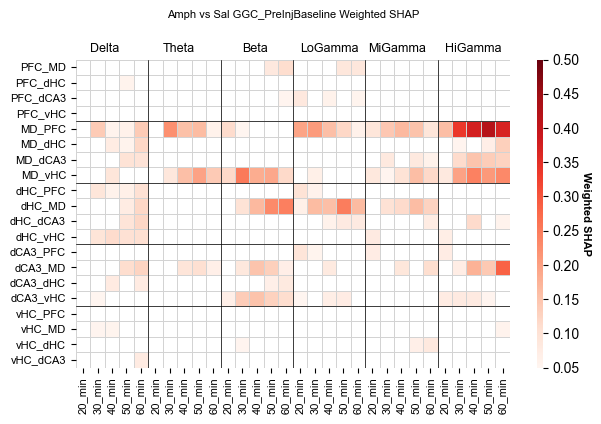

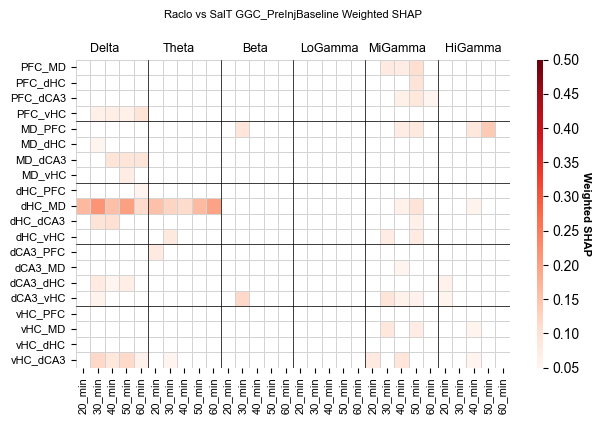

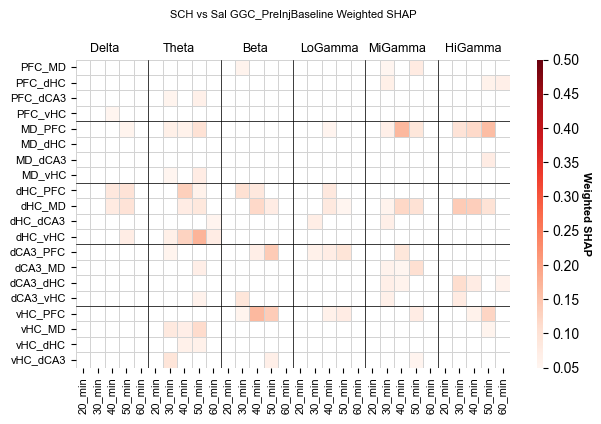

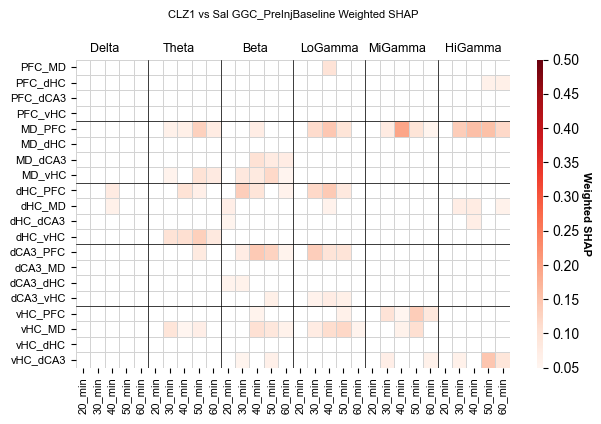

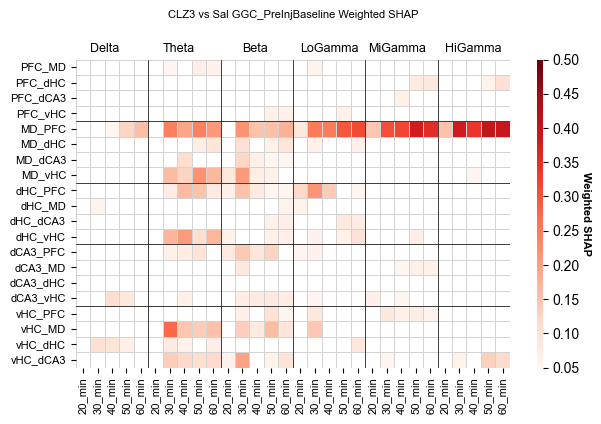

In [10]:
from matplotlib.pyplot import figure
#### Get feature columns excluding meta columns from the DataFrame
feature_columns = [col for col in df_tim_filt.columns if col not in metaCol]

# Initialize a dictionary to store segmented features for each frequency band
dict_seg_features = {}
for freq in freqBands:
    dict_seg_features[freq] = [fb for fb in df_drg_filt.columns if f'_{freq}' in fb]

# Initialize a DataFrame to store averaged accuracy
averaged_accu = pd.DataFrame(plt_accuracy_df.groupby(['freqBand', 'DrgCmb', 'tbin']).mean().to_records())
averaged_accu['TestAccuracy'] = averaged_accu['TestAccuracy'] - 0.5

# Set normalization flag
normalize_to_accu = True
norm_test_shap = {}

mask_thresh = 0.05
cmap = 'Reds';
vmin=mask_thresh;
vmax=0.5
TickLabsize = 8
textSize = 9

# Iterate through each drug in SHAP_test
for drg in SHAP_test.keys():
    tbin_df = pd.DataFrame()
    # Iterate through each time bin in SHAP_test for the current drug
    for tbin in SHAP_test[drg].keys():
        normalized_df = pd.DataFrame()
        # Check if SHAP values are segmented by frequency
        if len(list(SHAP_test[drg][tbin].keys())) == 1:
            cbar_ttl = 'SHAP'
            # If not segmented, normalize SHAP values directly
            dfdf = SHAP_test[drg][tbin]    
            MinMax_norm = (dfdf.values - dfdf.values.min(axis=1, keepdims=True)) / (dfdf.values.max(axis=1, keepdims=True) - dfdf.values.min(axis=1, keepdims=True))
            normalized_df = pd.DataFrame(MinMax_norm, columns=feature_columns)     
            normalized_df = pd.DataFrame(normalized_df.mean(axis = 0)).T
        if len(list(SHAP_test[drg][tbin].keys())) > 1:
            # If segmented, normalize SHAP values for each frequency and calculate weighted average if specified
            freq_shap = pd.DataFrame()
            for freq in SHAP_test[drg][tbin].keys():
                col_names = dict_seg_features[freq]
                dfdf = SHAP_test[drg][tbin][freq]   
                MinMax_norm = (dfdf.values - dfdf.values.min(axis=1, keepdims=True)) / (dfdf.values.max(axis=1, keepdims=True) - dfdf.values.min(axis=1, keepdims=True))
                freq_shap = pd.DataFrame(MinMax_norm, columns=col_names)
                freq_shap = pd.DataFrame(freq_shap.mean(axis=0)).T
                if normalize_to_accu:
                    # If normalize_to_accu is True, weight SHAP values by accuracy
                    cbar_ttl = 'Weighted SHAP'
                    for index, row in averaged_accu.iterrows():
                        if (row['DrgCmb'] == drg and
                            row['tbin'] == tbin and
                            row['freqBand'] == freq):
                            val = row['TestAccuracy']                            
                            freq_shap = freq_shap * val ## Multiply the (mean_accuracy - chance_lev accuracy) value to shap
                else:
                    cbar_ttl = 'SHAP'
                            
                normalized_df = pd.concat([normalized_df, freq_shap], axis=1)
        tbin_df[tbin] = normalized_df.T

    tbin_df.index.name = 'time_point'
    tbin_df.reset_index(inplace=True)
    norm_test_shap[drg] = tbin_df
    rearr_shap = pd.DataFrame()
    
    # Rearrange normalized SHAP values into a single DataFrame
    for freq in freqBands:
        temp_df = norm_test_shap[drg][norm_test_shap[drg]['time_point'].isin(dict_seg_features[freq])]
        temp_df = temp_df.drop(['time_point'], axis=1)
        
        temp_df.rename(columns=lambda x: x + f'_{freq}', inplace=True)
        temp_df.reset_index(inplace=True)    
        rearr_shap = pd.concat([rearr_shap, temp_df], axis=1)    
        rearr_shap = rearr_shap.drop(['index'], axis=1)

    # Remove columns with '10_min_' in the name for plotting
    drop_cols_to_plt = [col for col in rearr_shap.columns if f'10_min_' in col]
    shap2plt = rearr_shap.drop(drop_cols_to_plt, axis=1)           
    mask = shap2plt[shap2plt > mask_thresh]
    
    # Generate labels for y-axis and x-axis
    ylabels = [column.replace(f'_{freq}', '') for column in dict_seg_features[freq]] 
    ylabels = [string.replace('CA3', 'dCA3') for string in ylabels] ## 
    ylabels = [string.replace('dHC', 'dCA1') for string in ylabels]
    xlabels = ['_'.join(column.split('_')[:-1]) for column in shap2plt.columns]

    fig_names = f'{drg} {sheet_name} {cbar_ttl}'
    figsize=(7,4);

    f = figure(figsize=figsize)
    ax = sns.heatmap(shap2plt, annot= False, fmt="", vmin=vmin,  vmax=vmax,
                     annot_kws={"size": 15, 'weight': 'bold', 'color':'k', "ha": 'center',"va": 'center'},                 
                     cmap = cmap ,cbar_kws= {"shrink": 1, 'aspect':50},
                     linewidths=0.5, linecolor='lightgray', mask=mask.isnull())
    
    ax.axvline(x=5, linewidth=0.5, color="k")    
    ax.axvline(x=10, linewidth=0.5, color="k")
    ax.axvline(x=15,linewidth=0.5, color="k")
    ax.axvline(x=20,linewidth=0.5, color="k")
    ax.axvline(x=25,linewidth=0.5, color="k")
    
    
    ax.axhline(y=4, linewidth=0.5, color="k")    
    ax.axhline(y=8, linewidth=0.5, color="k")    
    ax.axhline(y=12, linewidth=0.5, color="k")    
    ax.axhline(y=16, linewidth=0.5, color="k")    
    ax.axhline(y=20, linewidth=0.5, color="k")    
    ax.axhline(y=24, linewidth=0.5, color="k")    
    ax.axhline(y=28, linewidth=0.5, color="k")
    
    ax.text(1,-0.5,"Delta", size = textSize, weight = 'normal')    
    ax.text(6,-0.5,"Theta", size = textSize, weight = 'normal')    
    ax.text(11.5,-0.5,"Beta", size = textSize, weight = 'normal')
    ax.text(15.5,-0.5,"LoGamma", size = textSize, weight = 'normal')
    ax.text(20.2,-0.5,"MiGamma", size = textSize, weight = 'normal')
    ax.text(25.5,-0.5,"HiGamma", size = textSize, weight = 'normal')
    
    ax.set_yticklabels(ylabels, rotation='horizontal',
                       size = TickLabsize, weight = 'normal')
    ax.set_xticklabels(xlabels, rotation=90, size = TickLabsize,
                       weight = 'normal', horizontalalignment= 'center',
                       verticalalignment="top")
    ax.set_title(fig_names, size = TickLabsize, weight = 'normal', pad = 30)
    ax.collections[0].colorbar.set_label(cbar_ttl, weight = 'bold',
                                         size = TickLabsize, rotation = 270,
                                         labelpad = TickLabsize)

    figName = f' {fig_names}.pdf' 
    figName2 = f' {fig_names}.jpg' 
    
    if save_fig:
        plt.rcParams['pdf.use14corefonts'] = True
        plt.rcParams["font.family"] = "Arial"
        plt.savefig(figName,  dpi = 300, bbox_inches='tight', transparent=True, metadata={'Creator': None})
        plt.savefig(figName2,  dpi = 300, bbox_inches='tight', transparent=True)
    